In [13]:
##PYTHON SET UP
import numpy
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import sys
sys.path.append("..")
from ds_utils.decision_surface import *

%matplotlib inline
sns.set(style='ticks', palette='Set2')

#important cross training/split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#import decision tree classifier model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

#import logisitc regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#import linear regression model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

#import MLPclassifier 
from sklearn.neural_network import MLPClassifier

#import random forest model
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

#basketball stats glossary: https://www.basketball-reference.com/about/glossary.html
#advanced stats = combination of single attribute variable (e.g. points, rebounds)

In [2]:
##IMPORT DATA
#import basketball player data
basketball_url = "https://raw.githubusercontent.com/vin792/basketball/master/Cleaned%20Database_NBA_DS%20Project_1%20April%202018.csv"
raw_df = pd.read_csv(basketball_url, header='infer', delimiter=',')

#group by player name and calculate average stats for first 3 seasons in the league
basketball_df = raw_df.groupby(['Player']).mean().drop(columns=['Selecting players with non-duplicate rows',
       'Selecting right data for players with duplicates', 'Flag']).dropna()

#column names
basketball_df.columns.get_values()

array(['S. No.', 'All-Star (1/0)', 'First Year', 'Year (i)', 'Year', 'G',
       'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype=object)

In [3]:
##FEATURE ENGINEERING - Information gain
#calculating IG Gain for all features

def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()
    
    # compute probas
    probas = target_counts/total
    
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    
    tot = float(df.shape[0])
    
    
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot

def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0

    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

def feature_igs_and_thresholds(df, info_columns, target_column, criteria=information_gain):
    IG_scores = []
    
    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)
        
        dict_temp = {'ig': ig, 'thresh': thresh, 'column': info_column}
        
        IG_scores.append(dict_temp)

    return IG_scores

all_features = ['G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

#calculate information gains and thresholds for all features and store in dataframe
all_feature_igs_thresholds = feature_igs_and_thresholds(basketball_df, all_features, 'All-Star (1/0)')
ig_gains_df = pd.DataFrame(all_feature_igs_thresholds)

#order of information gains, highest to lowest
ig_gains_df.sort_values('ig', ascending = False)

,column,ig,thresh
22,VORP,0.190981,1.100000
17,WS,0.190288,3.766667
44,PTS,0.174234,863.000000
23,FG,0.174132,336.000000
15,OWS,0.173463,1.833333
34,FTA,0.168101,197.666667
24,FGA,0.165603,689.000000
33,FT,0.161581,129.666667
2,MP,0.161450,1680.666667
30,2PA,0.157693,528.666667


In [4]:
##FEATURE ENGINEERING - Linear L1 regression to determine sparse coeffecients (helps to isolate the multicollinearty problem)
#create linear object
LinearRegression = linear_model.Lasso(alpha=.6) #increasing the alpha further penalizes features with multicollinearity
LinearRegression.fit(basketball_df[all_features], basketball_df['All-Star (1/0)'])

#list to store coefficient values
coefficients = []

#loop through coefficient values and pair with feature name
for i in range(0, len(all_features)):
    feature_coefficient = {'feature': all_features[i], 'coef_val': LinearRegression.coef_[i]}
    coefficients.append(feature_coefficient)

#create dataframe to store feature and coefficient values
l1_coefficients_df = pd.DataFrame(coefficients)
l1_coefficients_df.sort_values('coef_val', ascending=False)

,coef_val,feature
44,0.001053,PTS
39,0.000571,AST
38,0.000486,TRB
33,0.000405,FT
34,0.000052,FTA
40,0.000000,STL
41,0.000000,BLK
37,0.000000,DRB
36,0.000000,ORB
35,-0.000000,FT%


In [5]:
##FEATURE ENGINEERING
#Feature vectors to try based on IG and L1 results

#based on L1 linear regression, designed to handle multicollinearity issue 
#(i.e. the model set those varialbes with high multicollinearity to 0, hence the penalty on advance stats)
fvector_no_adv_stats = ['PTS', 'AST', 'TRB', 'BLK', 'FT', 'MP', 'FGA', 'PF']

#based on top 15 in information gain
fvector_top_15_ig = ['VORP', 'WS', 'PTS', 'FG', 'OWS', 'FTA', 'FGA', 'FT', 'MP', '2PA', '2P', 'PER', 'TOV', 'OBPM', 'GS']

#based on top 2 advanced stats in information gain
fvector_top_2_adv_stats = ['VORP', 'WS']

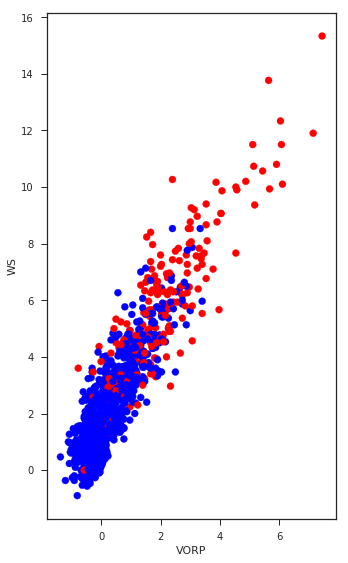

In [6]:
##FEATURE ENGINEERING - Decision surfaces
#function to plot decision surfaces from feature vector function
def plot_decision_surface(df, feature_vector, target_variable):
    
    rows = 11
    cols = 5
    ct = 0
    
    plt.figure(figsize=[30,11*rows])
    for i in range(len(feature_vector)-1):
        for j in range(i+1, len(feature_vector)): 
            ct = ct + 1
            plt.subplot(rows, cols, ct)
            xlabel = feature_vector[i] 
            ylabel = feature_vector[j] 
            Decision_Surface(df[feature_vector], xlabel, ylabel, df[target_variable], None) 

#call function, swap out middle term with the feature vector you want to see decision surfaces for
# fyi if vector is too large, jupyter won't save
plot_decision_surface(basketball_df, fvector_top_2_adv_stats, 'All-Star (1/0)')

In [7]:
##SPLIT DATA SETS INTO TRAINING AND TEST FOR EACH FEATURE VECTOR
#Split for no advanced sets features
Xnadv_train, Xnadv_test, Ynadv_train, Ynadv_test = train_test_split(basketball_df[fvector_no_adv_stats], basketball_df['All-Star (1/0)'], train_size=0.60, random_state=42)

#Split for top 15 IG features
X15_train, X15_test, Y15_train, Y15_test = train_test_split(basketball_df[fvector_top_15_ig], basketball_df['All-Star (1/0)'], train_size=0.60, random_state=42)

#Split for top 2 advanced IG features
Xadv2_train, Xadv2_test, Yadv2_train, Yadv2_test = train_test_split(basketball_df[fvector_top_2_adv_stats], basketball_df['All-Star (1/0)'], train_size=0.60, random_state=42)

#Split for all features
Xall_train, Xall_test, Yall_train, Yall_test = train_test_split(basketball_df[all_features], basketball_df['All-Star (1/0)'], train_size=0.60, random_state=42)

In [8]:
##TESTING AUC OF FEATURE VECTORS USING LOGISTIC REGRESSION MODELS
#Create logisitic regression model object
Logistic_Regression = LogisticRegression(C = 1)

aucs_regression_logistic = []

#Using no advanced stats feature vector
Logistic_Regression.fit(Xnadv_train, Ynadv_train)
probas = Logistic_Regression.predict_proba(Xnadv_test)[:, 1]
auc = metrics.roc_auc_score(Ynadv_test, probas)
aucs_regression_logistic.append({"Feature_Vector" : "No Adv Stats", "AUC" : auc})

#Using top 15 IG feature vector
Logistic_Regression.fit(X15_train, Y15_train)
probas = Logistic_Regression.predict_proba(X15_test)[:, 1]
auc = metrics.roc_auc_score(Y15_test, probas)
aucs_regression_logistic.append({"Feature_Vector" : "Top 15", "AUC" : auc})
    
#Using top 2 advanced IG feature vector
Logistic_Regression.fit(Xadv2_train, Yadv2_train)
probas = Logistic_Regression.predict_proba(Xadv2_test)[:, 1]
auc = metrics.roc_auc_score(Yadv2_test, probas)
aucs_regression_logistic.append({"Feature_Vector" : "Top 2 Adv Stats", "AUC" : auc})

#Using all features feature vector
Logistic_Regression.fit(Xall_train, Yall_train)
probas = Logistic_Regression.predict_proba(Xall_test)[:, 1]
auc = metrics.roc_auc_score(Yall_test, probas)
aucs_regression_logistic.append({"Feature_Vector" : "All Features", "AUC" : auc})

auc_regression_logistic_df = pd.DataFrame(aucs_regression_logistic)
auc_regression_logistic_df

,AUC,Feature_Vector
0,0.894016,No Adv Stats
1,0.902283,Top 15
2,0.892184,Top 2 Adv Stats
3,0.895449,All Features


In [9]:
##TESTING AUC OF FEATURE VECTORS USING TREE DECISION MODELS
#Create decision tree model object
Decision_Tree = DecisionTreeClassifier(min_samples_leaf=50)

aucs_regression_tree = []

#Using no advanced stats feature vector
Decision_Tree.fit(Xnadv_train, Ynadv_train)
auc = roc_auc_score(Ynadv_test, Decision_Tree.predict_proba(Xnadv_test)[:,1])
aucs_regression_tree.append({"Feature_Vector" : "No Adv State", "AUC" : auc})

#Using top 15 IG feature vector
Decision_Tree.fit(X15_train, Y15_train)
auc = roc_auc_score(Y15_test, Decision_Tree.predict_proba(X15_test)[:,1])
aucs_regression_tree.append({"Feature_Vector" : "Top 15", "AUC" : auc})

#Using top 2 advanced IG feature vector
Decision_Tree.fit(Xadv2_train, Yadv2_train)
auc = roc_auc_score(Yadv2_test, Decision_Tree.predict_proba(Xadv2_test)[:,1])
aucs_regression_tree.append({"Feature_Vector" : "Top 2 Adv Stats", "AUC" : auc})

#Using all features feature vector
Decision_Tree.fit(Xall_train, Yall_train)
auc = roc_auc_score(Yall_test, Decision_Tree.predict_proba(Xall_test)[:,1])
aucs_regression_tree.append({"Feature_Vector" : "All Features", "AUC" : auc})

auc_regression_tree_df = pd.DataFrame(aucs_regression_tree)
auc_regression_tree_df

,AUC,Feature_Vector
0,0.871612,No Adv State
1,0.871918,Top 15
2,0.854117,Top 2 Adv Stats
3,0.862595,All Features


In [10]:
##DETERMINING WHICH OF TOP 15 FEATURE SET TO USE IN COMBINATION
#create combination function
import itertools
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#determine optimal feature combination
aucs_combo_regression = []

for result in powerset(fvector_top_15_ig):
    fvector = list(result)
    
    if len(fvector) > 0:
        Xcombo_train, Xcombo_test, Ycombo_train, Ycombo_test = train_test_split(basketball_df[fvector], basketball_df['All-Star (1/0)'], train_size=0.60, random_state=42)
        Logistic_Regression.fit(Xcombo_train, Ycombo_train)
        probas = Logistic_Regression.predict_proba(Xcombo_test)[:, 1]
        auc = metrics.roc_auc_score(Ycombo_test, probas)
        aucs_combo_regression.append({"Feature_Vector" : fvector, "AUC" : auc})

auc_combo_regression_df = pd.DataFrame(aucs_combo_regression)
auc_combo_regression_df.sort_values('AUC', ascending=False)

,AUC,Feature_Vector
20542,0.915175,"[WS, PTS, FTA, FGA, FT, MP, TOV, GS]"
13630,0.914894,"[WS, PTS, FGA, FT, MP, TOV, GS]"
13525,0.914870,"[WS, PTS, FTA, FGA, MP, TOV, GS]"
21004,0.914800,"[WS, FG, FTA, FGA, FT, MP, TOV, GS]"
7647,0.914776,"[WS, FG, FGA, FT, MP, TOV]"
7317,0.914729,"[WS, PTS, FGA, FT, MP, TOV]"
13494,0.914635,"[WS, PTS, FTA, FGA, FT, MP, TOV]"
20416,0.914494,"[WS, PTS, OWS, FGA, FT, MP, TOV, GS]"
26296,0.914471,"[WS, PTS, OWS, FTA, FGA, FT, MP, TOV, GS]"
13987,0.914471,"[WS, FG, FTA, FGA, MP, TOV, GS]"


In [11]:
##FEATURE VECTOR SELECTED
feature_vector = ['WS', 'PTS', 'FTA', 'FGA', 'FT', 'MP', 'TOV', 'GS']

#Split into training and test data
X_train, X_test, Y_train, Y_test = train_test_split(basketball_df[feature_vector], basketball_df['All-Star (1/0)'], train_size=0.60, random_state=42)

In [18]:
##TESTING MULTIPLE MODELS

aucs = []

#Logisitic Regression
Logistic_Regression = LogisticRegression(C = 1)
Logistic_Regression.fit(X_train, Y_train)
probas = Logistic_Regression.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(Y_test, probas)
aucs.append({"Model" : "Logistic Regression", "AUC" : auc})

#Decision Tree
Decision_Tree = DecisionTreeClassifier(min_samples_leaf=50)
Decision_Tree.fit(X_train, Y_train)
auc = roc_auc_score(Y_test, Decision_Tree.predict_proba(X_test)[:,1])
aucs.append({"Model" : "Decision Tree", "AUC" : auc})

#Random Forest
Random_Forest = RandomForestClassifier(n_estimators=20)
Random_Forest.fit(X_train, Y_train)
auc = roc_auc_score(Y_test, Random_Forest.predict_proba(X_test)[:,1])
aucs.append({"Model" : "Random Forest", "AUC" : auc})

#MLPClassifier (Neural Network)
MLP_Classifier = MLPClassifier(hidden_layer_sizes=5)
MLP_Classifier.fit(X_train, Y_train)
probas = MLP_Classifier.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(Y_test, probas)
aucs.append({"Model" : "MLP", "AUC" : auc})

auc_df = pd.DataFrame(aucs)
auc_df

,AUC,Model
0,0.915175,Logistic Regression
1,0.850277,Decision Tree
2,0.883237,Random Forest
3,0.235733,MLP


In [19]:
##TUNING LOGISTIC REGRESSION
#Logistic Regression AUC based on different regularization values
aucs_regression = []
for c in [0.001, 0.01, 0.1, 1.0, 10, 100]:
    model_regression = LogisticRegression(C=c)
    model_regression.fit(X_train, Y_train)
    
    probas = model_regression.predict_proba(X_test)[:, 1]
    auc = metrics.roc_auc_score(Y_test, probas)
    
    aucs_regression.append({"C":c, "AUC":auc})

auc_regression_df = pd.DataFrame(aucs_regression).set_index("C")
auc_regression_df

,AUC
C,
0.001,0.751890
0.010,0.796581
0.100,0.897187
1.000,0.915175
10.000,0.912029
100.000,0.911441


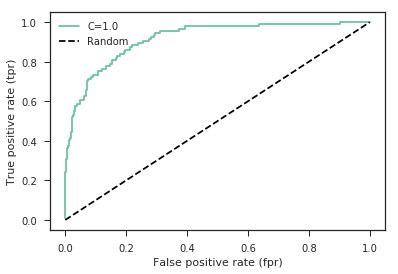

In [27]:
#ROC CURVE
model = LogisticRegression(C=1.0)
model.fit(X_train, Y_train)

# Get the probability of Y_test records being = 1
Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

# Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    

# Plot the ROC curve
plt.plot(fpr, tpr, label="C=%s" % c)
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=2)
plt.show()

In [26]:
#MODEL COEFFICIENTS
#list to store coefficient values
model_coefficients = []

#loop through coefficient values and pair with feature name
for i in range(0, len(feature_vector)):
    feature_coefficient = {'feature': feature_vector[i], 'coef_val': model.coef_[0][i]}
    model_coefficients.append(feature_coefficient)

#create dataframe to store feature and coefficient values
model_coefficients_df = pd.DataFrame(model_coefficients)
model_coefficients_df

,coef_val,feature
0,0.799347,WS
1,-0.003075,PTS
2,-0.000103,FTA
3,0.004752,FGA
4,0.007549,FT
5,-0.001716,MP
6,0.008503,TOV
7,0.004378,GS


In [46]:
##RUN MODEL ON FULL DATA SET
all_star_predictions = model.predict(basketball_df[feature_vector])
basketball_df_temp = basketball_df[feature_vector]
basketball_df_predictions_set = basketball_df_temp.assign(allstar_actual = basketball_df['All-Star (1/0)'], allstar_predicted = all_star_predictions)

In [48]:
pd.options.display.max_rows = 2000
basketball_df_predictions_set.sort_values(by=['allstar_actual', 'allstar_predicted'], ascending=False)

,WS,PTS,FTA,FGA,FT,MP,TOV,GS,allstar_actual,allstar_predicted
Player,,,,,,,,,,
Al Horford,7.733333e+00,914.000000,229.000000,703.000000,172.333333,2542.333333,120.666667,75.000000,1.0,1.0
Allen Iverson*,6.766667e+00,1609.666667,517.666667,1322.333333,376.000000,2728.333333,249.333333,67.333333,1.0,1.0
Alonzo Mourning*,7.966667e+00,1523.000000,615.333333,1021.666667,472.666667,2534.333333,225.333333,71.333333,1.0,1.0
Alvin Robertson,5.666667e+00,1184.333333,273.333333,985.666667,209.333333,2420.000000,222.000000,56.333333,1.0,1.0
Amar'e Stoudemire,8.400000e+00,1439.666667,571.333333,1010.333333,404.333333,2494.666667,185.000000,68.000000,1.0,1.0
Andre Drummond,7.366667e+00,900.333333,284.000000,690.666667,112.666667,2121.333333,95.666667,57.666667,1.0,1.0
Andre Iguodala,7.266667e+00,1044.666667,370.000000,741.666667,290.333333,2944.666667,184.333333,80.000000,1.0,1.0
Andrei Kirilenko,9.366667e+00,1042.333333,412.333333,735.333333,324.333333,2419.666667,153.000000,43.000000,1.0,1.0
Andrew Toney,4.500000e+00,1280.000000,314.333333,1011.666667,237.333333,2050.333333,234.666667,41.000000,1.0,1.0
